Sky Sources in Difference Images
======

This notebook takes the sky sources from the diaSource catalog and compares them to the distribution expected from Gaussian noise.


In [1]:
import lsst.daf.butler as dafButler
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.spatial import cKDTree
from astropy.io import ascii
import math

In [2]:
b = dafButler.Butler("/repo/embargo", collections="u/elhoward/DM-44138/LSSTComCamSim")

In [3]:
diaSrc_refs = list(b.registry.queryDatasets("goodSeeingDiff_diaSrc"))
print("Number of DIASource catalogs: ", len(diaSrc_refs))

Number of DIASource catalogs:  20799


Single image
-----

In [4]:
diaSrc = b.get(diaSrc_refs[0])

In [5]:
snr = diaSrc['base_PsfFlux_instFlux'][diaSrc['sky_source']]/diaSrc['base_PsfFlux_instFluxErr'][diaSrc['sky_source']]

Text(0.5, 1.0, 'DIASources')

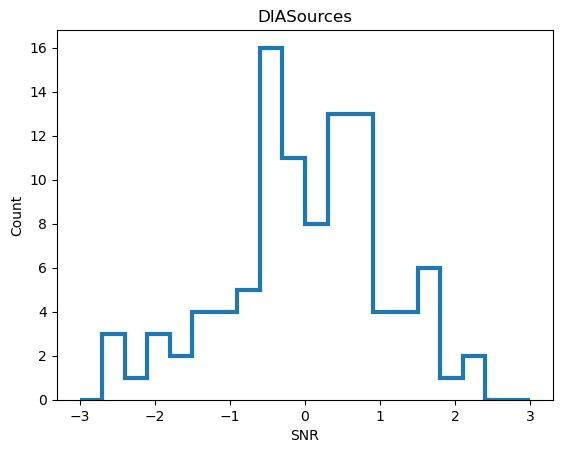

In [6]:
snr_hist, bins  = np.histogram(snr, range=(-3, 3), bins=20)
plt.stairs(snr_hist, bins, lw=3)
plt.xlabel("SNR")
plt.ylabel("Count")
plt.title("DIASources")

Sum of Multiple Images
-----

Text(0, 0.5, 'Count')

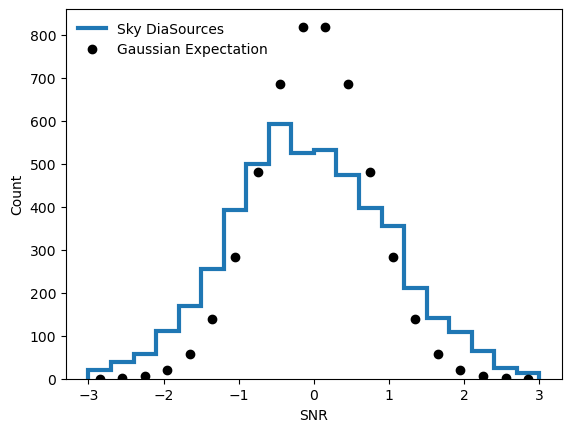

In [7]:
snr_hist_sum = np.zeros(20)
snr_hist_bins = np.linspace(-3, 3, 20 + 1)
snr_lists = []
for ref in diaSrc_refs[:50]:
    diaSrc = b.get(ref)
    snr = diaSrc['base_PsfFlux_instFlux'][diaSrc['sky_source']]/diaSrc['base_PsfFlux_instFluxErr'][diaSrc['sky_source']]
    snr_hist, _  = np.histogram(snr, bins=snr_hist_bins)
    snr_hist_sum += snr_hist
    snr_lists.append(np.array(snr))
plt.stairs(snr_hist_sum, snr_hist_bins, lw=3, label="Sky DiaSources")

plt.plot(0.5*(snr_hist_bins[1:]+snr_hist_bins[:-1]),
         np.sum(snr_hist_sum)*0.5*(erf(snr_hist_bins[1:]) - (erf(snr_hist_bins[:-1]))), 'ko', label="Gaussian Expectation")

plt.legend(loc=2, frameon=False)

plt.xlabel("SNR")
plt.ylabel("Count")

Correlation between nearby sky sources?
-----

This is a very speculative check on whether the sky sources show correlations with bright real objects, e.g. from extended wings of stars. 

In [8]:
_dists = []
_corr_fluxes = []

H_sum = np.zeros(20)
for ref in diaSrc_refs[:400]:
    diaSrc = b.get(ref)

    tree = cKDTree(np.vstack((diaSrc['base_SdssCentroid_x'][diaSrc['sky_source']],
               diaSrc['base_SdssCentroid_y'][diaSrc['sky_source']])).T)

    for pairs in tree.query_pairs(800):
        idx1, idx2 = pairs
        dist = np.sqrt((diaSrc['base_SdssCentroid_x'][diaSrc['sky_source']][idx1] - diaSrc['base_SdssCentroid_x'][diaSrc['sky_source']][idx2])**2 +
                       (diaSrc['base_SdssCentroid_y'][diaSrc['sky_source']][idx1] - diaSrc['base_SdssCentroid_y'][diaSrc['sky_source']][idx2])**2)
    
        snr1 = diaSrc['base_PsfFlux_instFlux'][diaSrc['sky_source']][idx1]/diaSrc['base_PsfFlux_instFluxErr'][diaSrc['sky_source']][idx1]
        snr2 = diaSrc['base_PsfFlux_instFlux'][diaSrc['sky_source']][idx2]/diaSrc['base_PsfFlux_instFluxErr'][diaSrc['sky_source']][idx2]
        
        _dists.append(dist)
        _corr_fluxes.append(snr1*snr2)

dists = np.array(_dists)
corr_fluxes = np.array(_corr_fluxes)
print(len(dists))

192516


Text(0, 0.5, 'Pair Count')

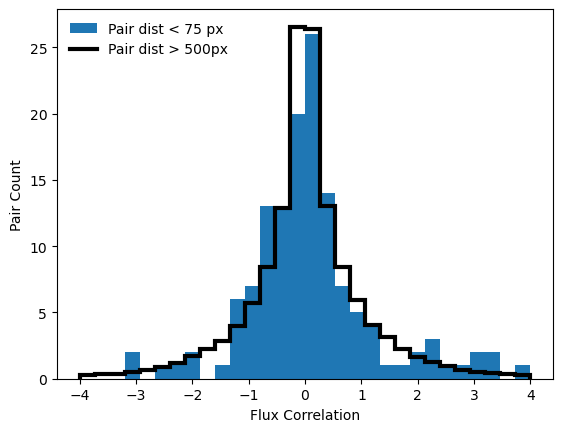

In [9]:
sel_close, = np.where((dists > 20) & (dists < 75))
sel_far, = np.where((dists > 500))

plt.hist(corr_fluxes[sel_close], range=(-4,4), bins=30, label="Pair dist < 75 px")

H_far, bins = np.histogram(corr_fluxes[sel_far], bins=30, range=(-4, 4))
plt.stairs(H_far/np.sum(H_far)*len(sel_close), bins, lw=3, color='k', label="Pair dist > 500px")
plt.legend(loc=2, frameon=False)
plt.xlabel("Flux Correlation")
plt.ylabel("Pair Count")

There is possibly some sort of weak correlation, but it doesn't seem very significant.

Sky Source Noise in Dense vs Sparse Fields
=====

Using a pre-provided table of DIASource counts on each visit, do the visits with more DIASources show any different noise properties? This is a check of whether noise misestimates might be the cause of elevated numbers of DIASources.

In [10]:
density_table = ascii.read("N_DIA_Sources_per_visit.csv", header_start=0, delimiter=',')

In [11]:
density_lookup = {visit: n_sources for (visit, n_sources) in zip(density_table['visit'],density_table['N_Sources'])}

Text(0, 0.5, 'N Visits')

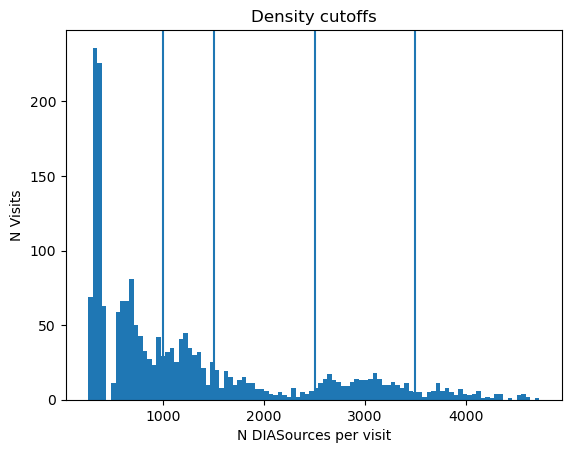

In [12]:
plt.hist(density_table['N_Sources'], bins=100)


plt.axvline(1000)
plt.axvline(1500)
plt.axvline(2500)
plt.axvline(3500)

plt.title("Density cutoffs")
plt.xlabel("N DIASources per visit")
plt.ylabel("N Visits")

In [13]:
low_refs = []
mid_refs = []
high_refs = []
for ref in diaSrc_refs:
    try:
        density = density_lookup[ref.dataId['visit']]
    except KeyError:
        continue
        
    if(density < 1000):
        low_refs.append(ref)
    elif((density > 1500) and (density < 2500)):
        mid_refs.append(ref)
    elif((density > 2500) and (density < 3500)):
        high_refs.append(ref)

print("Number of visits falling into low, medium, and high density categories: ", len(low_refs), len(mid_refs), len(high_refs))

Number of visits falling into low, medium, and high density categories:  9999 1719 2340


In [14]:
def make_histogram_from_refs(refs):
    snr_hist_sum = np.zeros(20)
    snr_hist_bins = np.linspace(-3, 3, 20 + 1)
    for ref in refs:
        diaSrc = b.get(ref)
        snr = diaSrc['base_PsfFlux_instFlux'][diaSrc['sky_source']]/diaSrc['base_PsfFlux_instFluxErr'][diaSrc['sky_source']]
        snr_hist, _  = np.histogram(snr, bins=snr_hist_bins)
        snr_hist_sum += snr_hist
    return (snr_hist_sum, snr_hist_bins)
    

In [15]:
low_hist, snr_hist_bins = make_histogram_from_refs(low_refs[:50])
mid_hist, _ = make_histogram_from_refs(mid_refs[:50])
high_hist, _ = make_histogram_from_refs(high_refs[:50])

Text(0, 0.5, 'Count')

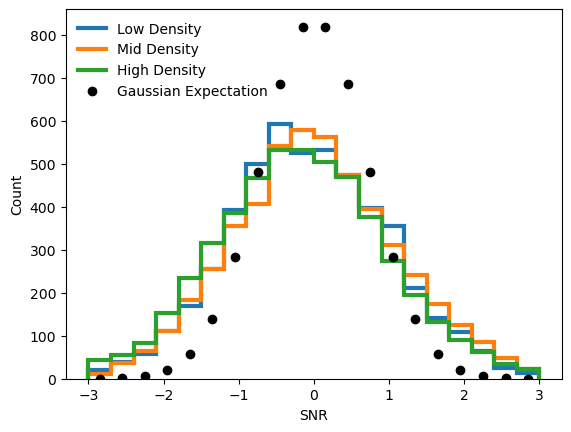

In [16]:
plt.stairs(low_hist, snr_hist_bins, lw=3, label="Low Density")
plt.stairs(mid_hist, snr_hist_bins, lw=3, label="Mid Density")
plt.stairs(high_hist, snr_hist_bins, lw=3, label="High Density")

plt.plot(0.5*(snr_hist_bins[1:]+snr_hist_bins[:-1]),
         np.sum(snr_hist_sum)*0.5*(erf(snr_hist_bins[1:]) - (erf(snr_hist_bins[:-1]))), 'ko', label="Gaussian Expectation")

plt.legend(loc=2, frameon=False)
plt.xlabel("SNR")
plt.ylabel("Count")

All three density categories have similar noise properties.